# 주제 :  기상청 날씨 데이터와 교통사고 데이터 간의 상관관계 분석
- 팀명 : 국민대민쑤

## 1. 보도자료

- 교통사고 예측 시, 기상 데이터를 활용하면 예측 오차를 개선할 수 있다는 것을 인지하였습니다. 교통사고에 미치는 기상요소는 **기온(평균, 최고, 최저), 습도, 풍속, 운량, 불쾌지수, 체감온도, 강수량** 등이라고 하는군요. 특히, **여름과 겨울** 에는 **최저기온, 운량, 체감온도** 와 교통사고의 상관성이 높고, 환절기에는 기상요소와 교통사고의 연관성이 상대적으로 낮다는 것을 발견했다 보도합니다.
- 날씨가 교통사고에 미치는 영향 :
이 중 날씨와 기상 요인은 일차적으로는 도로 환경에 큰 영향을 주며, 이차적으로는 운전자의 감정 상태나 운전 환경에도 영향을 미친다. 따라서 기상 요인과 교통 사고 발생간의 연관성을 분석하고, 그 피해를 정량화하여 정책적으로 반영할 필요성이 매우 높다. 이라는 공식적인 기상청 문서도 있다.

- "기상요인이 교통사고 발생에 미치는 영향 분석" 이라는 논문을 참고하여 기상요인과 교통사고가 밀접한 관계가 있음을 확인하여 주제를 선정하였음

[논문출처] : https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201514753131222&dbt=NART

## 2. 날씨와 교통사고 패턴 세부 분석 내용

### 폰트설정

In [ ]:
# 시작에 앞서 한글 폰트설정

def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인
    
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows" :
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 꼭 재시작 해야합니다.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨집니다.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq > /dev/null
        
        import matplotlib.font_manager as fm
        
        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
        
    return font_family

## 코드 실행환경

In [ ]:
import platform
print(platform.platform())
!cat /etc/issue.net
!python --version
!nvidia-smi

Linux-5.10.147+-x86_64-with-glibc2.29
Ubuntu 20.04.5 LTS
Python 3.8.10
Wed Feb 15 06:46:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                 

## 구글 코랩 사용시 구글 드라이브 연결 사용

In [ ]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/gdrive')

#코랩 환경 경로 설정 -> 자신에게 맞는 경로로 설정해주시면 됩니다 
DATA_PATH = '/content/gdrive/MyDrive/지역치안공모전/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import & Install

In [ ]:
# 코랩 기준 필요 라이브러리 설치

!pip install haversine
!pip install shap

In [ ]:
#Base & visualization
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

#Feature engineering
import datetime
from haversine import haversine

#Feature Selection
import shap

#Model
import lightgbm as lgb

font_family = get_font_family()
plt.rc("font", family=font_family)

## Fix Seed

In [ ]:
#Seed 고정
class CFG:
    SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [ ]:
kp2020 = pd.read_csv(DATA_PATH + 'KP2020.csv', encoding = 'cp949')
kp2021 = pd.read_csv(DATA_PATH + 'KP2021.csv', encoding = 'cp949')
npa2020 = pd.read_csv(DATA_PATH + 'NPA2020.csv', encoding = 'cp949')
codeBook = pd.read_excel(DATA_PATH + 'codeBook_v3.xlsx')

In [ ]:
# 외부데이터(기상청)
temp2020 = pd.read_csv(DATA_PATH + '2020년기상청관측데이터.csv', encoding = 'cp949')
temp2021 = pd.read_csv(DATA_PATH + '2021년기상청관측데이터.csv', encoding = 'cp949')
temp2022 = pd.read_csv(DATA_PATH + '2022년기상청관측데이터.csv', encoding = 'cp949')
temp2023 = pd.read_csv(DATA_PATH + '2023년기상청관측데이터.csv', encoding = 'cp949')
location = pd.read_csv(DATA_PATH + '관측지점정보.csv', encoding = 'cp949')

#### **외부데이터 설명**
- temp2020-temp2022 : 2020-2022년 날씨데이터
- temp2023 : 2023년 1월 18일까지 날씨데이터
- temp2023_02 : 20203년 1월 19일부터 2월 14일 09:00까지의 데이터
- location : 전국에 있는 기상관측소 위치 및위도,경도

[외부데이터 출처] : https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36

#Feature engineering

### 날씨데이터

In [ ]:
# 2020년1월부터 2020년1월18일까지 병합
temp_all = pd.concat([temp2020,temp2021,temp2022,temp2023]).sort_values(by=["지점", "일시"]).reset_index(drop=True)

In [ ]:
지점_list = [129, 133, 177, 232, 235, 236, 238, 239]
temp_fine = pd.DataFrame(columns=['지점', '지점명', '일시', '기온(°C)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)','이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '전운량(10분위)', '시정(10m)','지면온도(°C)'])

In [ ]:
# 시계열데이터에서 일반적으로 결측치 처리에 좋은 interpolate(보간법)을 이용하여 결측치 처리
# interpolate 특성상 지역별로 결측치 처리를 안하면 다른 지역 데이터가 들어갈수 있으므로 지역별로 결측치 처리
for i in range(len(지점_list)):
  temp_fine = pd.concat([temp_fine,temp_all.query(f'지점=={지점_list[i]}').interpolate()])

In [ ]:
# 세종시 미관측데이터 대전시 데이터로 보강
cloud_list = temp_fine.query('지점명=="대전"')['전운량(10분위)'][:1547].to_list()
temp_fine.loc[range(187152, 188699), '전운량(10분위)'] = cloud_list

In [ ]:
# 전운량데이터의 경우 10분위로 이루어져있는 범주형 피처
# interpolate때문에 소수점발생하므로 반올림진행
temp_fine["전운량(10분위)"] = temp_fine["전운량(10분위)"].round()

### 기상관측소 데이터

In [ ]:
# location데이터에서 충남,대전,세종에 있는 기상 관측소만 추출
location = location.query(f'지점 == {지점_list}')
location = location.drop_duplicates(subset='지점', keep='first').reset_index(drop=True)
location['위도'] = location['위도'].astype(float)

### 교통사고 데이터

In [ ]:
# 교통사고 데이터만 추출
kp2020_traffic = kp2020.query('EVT_CL_CD == 401').reset_index(drop=True)
kp2021_traffic = kp2021.query('EVT_CL_CD == 401').reset_index(drop=True)
npa2020_traffic = npa2020.query('EVT_CL_CD == 401').reset_index(drop=True)

In [ ]:
# 교통사고 데이터중 위도,경도 결측치 제거
kp2020_traffic = kp2020_traffic.dropna(subset=['HPPN_X']).reset_index(drop=True)
kp2021_traffic = kp2021_traffic.dropna(subset=['HPPN_X']).reset_index(drop=True)
npa2020_traffic = npa2020_traffic.dropna(subset=['HPPN_X']).reset_index(drop=True)
npa2020_traffic = npa2020_traffic[npa2020_traffic.HPPN_X != 0]

In [ ]:
# npa2020,와 kp2020,kp2021 날짜 형식 통일
# 1시간 이내 데이터 예측이므로 ex) 00:00~00:59분까지 00:00으로 통일
def add_zeros(x):
    x = str(x)
    return x.zfill(6)

npa2020_traffic['RECV_CPLT_TM'] = npa2020_traffic['RECV_CPLT_TM'].apply(add_zeros)
npa2020_traffic['RECV_CPLT_DM'] = npa2020_traffic['RECV_CPLT_DT'].astype(str).str[:4] + '-' + npa2020_traffic['RECV_CPLT_DT'].astype(str).str[4:6] + '-' + npa2020_traffic['RECV_CPLT_DT'].astype(str).str[6:8] + ' ' + npa2020_traffic['RECV_CPLT_TM'].astype(str).str[:2]+':00'
npa2020_traffic = npa2020_traffic.drop(columns=['RECV_CPLT_DT','RECV_CPLT_TM','HPPN_OLD_ADDR'])

kp2020_traffic['RECV_CPLT_DM'] = '20' + kp2020_traffic['RECV_CPLT_DM']
kp2020_traffic['RECV_CPLT_DM'] = pd.to_datetime(kp2020_traffic['RECV_CPLT_DM'])
kp2020_traffic['RECV_CPLT_DM'] = kp2020_traffic['RECV_CPLT_DM'].dt.strftime('%Y-%m-%d %H')
kp2020_traffic['RECV_CPLT_DM'] = kp2020_traffic['RECV_CPLT_DM'] + ':00'

kp2021_traffic['RECV_CPLT_DM'] = '20' + kp2021_traffic['RECV_CPLT_DM']
kp2021_traffic['RECV_CPLT_DM'] = pd.to_datetime(kp2021_traffic['RECV_CPLT_DM'])
kp2021_traffic['RECV_CPLT_DM'] = kp2021_traffic['RECV_CPLT_DM'].dt.strftime('%Y-%m-%d %H')
kp2021_traffic['RECV_CPLT_DM'] = kp2021_traffic['RECV_CPLT_DM'] + ':00'

In [ ]:
# 교통사고데이터 병합
kp_all = pd.concat([kp2020_traffic,kp2021_traffic])
kp_all = kp_all.drop(columns=['RECV_DEPT_NM','HPPN_PNU_ADDR'])
traffic_all = pd.concat([npa2020_traffic,kp_all]).reset_index(drop=True)

In [ ]:
# haversine : 위도,경도 거리 계산 라이브러리(따로 설치필요)
# 교통사고데이터 위도,경도와 충남,대전,세종에 있는 모든 기상관측소 위도,경도 거리 계산 후 제일 가까운 관측소 위도,경도를 추출
traffic_all['지점'] = traffic_all.apply(lambda x: location.loc[np.argmin([haversine((x.HPPN_Y, x.HPPN_X), (loc.위도, loc.경도), unit='km') for i, loc in location.iterrows()]), '지점'], axis=1)

In [ ]:
# 지점별로 정렬 후 시간순으로 정렬
traffic_all = traffic_all[['지점','RECV_CPLT_DM']].sort_values(by=["지점", "RECV_CPLT_DM"]).reset_index(drop=True)

In [ ]:
# 교통사고 데이터에 '사고유무'컬럼 추가 후 날씨 데이터와 병합
# '지점'과'일시'를 기준으로 병합하여 날씨데이터 기준 1시간 간격 교통사고 유무를 파악할 수 있음
traffic_all['사고유무'] = 1
traffic_all.drop_duplicates(subset=['지점','RECV_CPLT_DM']).reset_index(drop=True)
traffic_all.rename(columns = {"RECV_CPLT_DM": "일시"}, inplace = True)
X = pd.merge(temp_fine, traffic_all, on=['지점', '일시'], how='left')
X['사고유무'] = X['사고유무'].fillna(0)
X['일시'] = pd.to_datetime(X['일시'],format='%Y-%m-%d %H')

### 모델 생성 및 성능 확인을 위한 Train Test split

In [ ]:
# Train데이터 : 2020년1월1일 ~ 2022년 1월18일22시 데이터
# Test데이터 : 2022년1월18일23시 ~ 2023년1월18일23시 데이터
train_01 = X.query('"2020-01-01 00:00:00" <= 일시 <= "2020-12-31 23:00:00"')
train_02 = X.query('"2021-01-01 00:00:00" <= 일시 <= "2021-12-31 23:00:00"')
train_03 = X.query('"2022-01-01 00:00:00" <= 일시 <= "2022-12-31 23:00:00"')
train_01 = train_01.drop(columns='지점명')
train_02 = train_02.drop(columns='지점명')
train_03 = train_03.drop(columns='지점명')
train_01.set_index('일시', drop=True, inplace=True)
train_02.set_index('일시', drop=True, inplace=True)
train_03.set_index('일시', drop=True, inplace=True)

## 2.1. 분석 개요

In [ ]:
# 자료
print("자료 : ", train_01.columns.tolist())

자료 :  ['지점', '기온(°C)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '전운량(10분위)', '시정(10m)', '지면온도(°C)', '사고유무']


In [ ]:
# 기간
print("기간 : 분석기간(", train_01.index[0], "~", train_01.index[train_01.shape[0]-1], ")")

기간 : 분석기간( 2020-01-01 00:00:00 ~ 2020-12-31 23:00:00 )


In [ ]:
# 분석내용
print("분석내용 : 기간, 기상요소 반영 전후의 충남,대전,세종 교통사고 분석")

분석내용 : 기간, 기상요소 반영 전후의 충남,대전,세종 교통사고 분석


In [ ]:
def resample_summary(ts_data, col_nm, time_span, func_list):
    
    df_summary = pd.DataFrame() # blank DataFrame to store results

    # resampler with column name by time span (group by)
    resampler = ts_data[col_nm].resample(time_span)

    # aggregation functions with suffix name
    if 'first' in func_list:
        df_summary[col_nm + '_' + time_span + '_first'] = resampler.first()

    if 'last' in func_list:
        df_summary[col_nm + '_' + time_span + '_last'] = resampler.last()

    if 'sum' in func_list:
        df_summary[col_nm + '_' + time_span + '_sum'] = resampler.sum()

    if 'cumsum' in func_list:
        df_summary[col_nm + '_' + time_span + '_cumsum'] = resampler.sum().cumsum()

    if 'min' in func_list:
        df_summary[col_nm + '_' + time_span + '_min'] = resampler.min()

    if 'max' in func_list:
        df_summary[col_nm + '_' + time_span + '_max'] = resampler.max()

    if 'mean' in func_list:
        df_summary[col_nm + '_' + time_span + '_mean'] = resampler.mean()

    if 'median' in func_list:
        df_summary[col_nm + '_' + time_span + '_median'] = resampler.median()

    if 'range' in func_list:
        df_summary[col_nm + '_' + time_span + '_range'] = resampler.max() - resampler.min()

    if 'var' in func_list:
        df_summary[col_nm + '_' + time_span + '_var'] = resampler.var() # sample variance

    if 'stddev' in func_list:
        df_summary[col_nm + '_' + time_span + '_stddev'] = np.sqrt(resampler.var())

    return df_summary

In [ ]:
func_list = ['mean', 'min', 'max', 'var', '_stddev']
rs_01 = resample_summary(train_01, '사고유무', '1D', func_list)
rs_02 = resample_summary(train_02, '사고유무', '1D', func_list)
rs_03 = resample_summary(train_03, '사고유무', '1D', func_list)

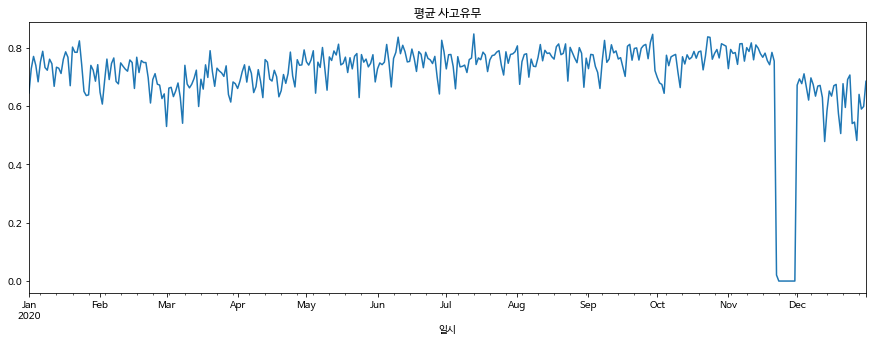

In [ ]:
# 2020년 일별 평균 교통사고
plt.figure(figsize=(15, 5))
plt.title('평균 사고유무')
rs_01['사고유무_1D_mean'].plot()

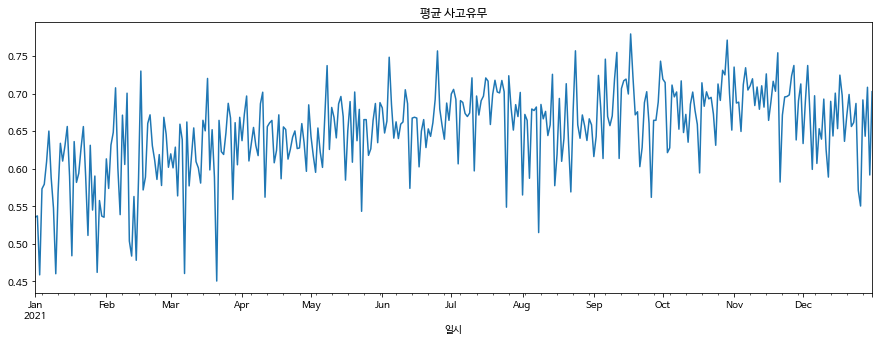

In [ ]:
# 2021년 일별 평균 교통사고
plt.figure(figsize=(15, 5))
plt.title('평균 사고유무')
rs_02['사고유무_1D_mean'].plot()

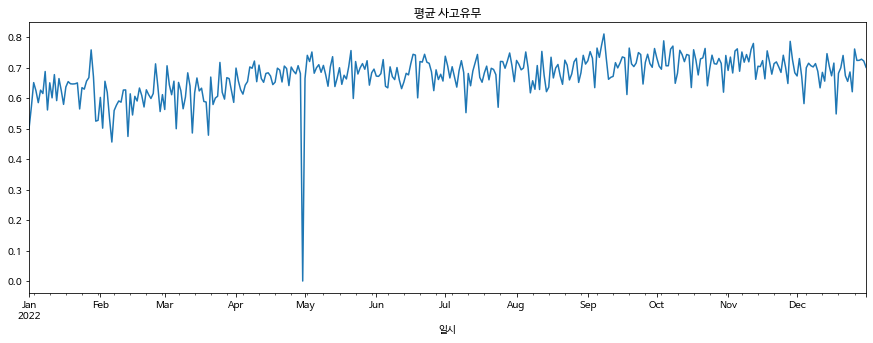

In [ ]:
# 2022년 일별 평균 교통사고
plt.figure(figsize=(15, 5))
plt.title('평균 사고유무')
rs_03['사고유무_1D_mean'].plot()

- 여름과 겨울 에는 교통사고의 상관성이 높고, 환절기에는 교통사고의 연관성이 상대적으로 낮은것을 볼 수 있다.

## 2.2. 분석 진행

- Shap를 이용한 피처 중요도 시각화

In [ ]:
# 모든 날짜가 들어있는 데이터 X에서 y_label 분리
y_train = X['사고유무']
X_index = X.iloc[:,:3]
X_train = X.drop(columns='사고유무')
X_train = X_train.iloc[:,3:]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


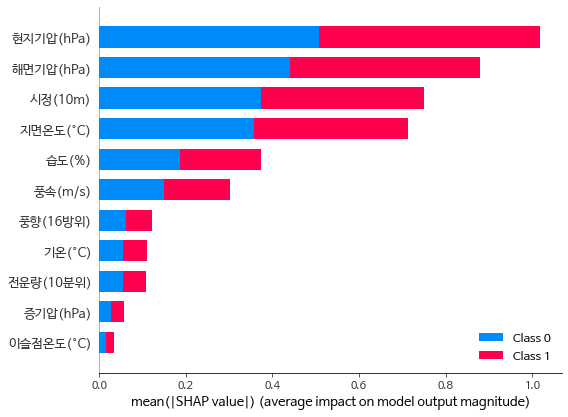

,column_name,shap_importance
6,현지기압(hPa),0.508301
7,해면기압(hPa),0.44012
9,시정(10m),0.374821
10,지면온도(°C),0.356811
3,습도(%),0.187015
1,풍속(m/s),0.150613
2,풍향(16방위),0.061447
0,기온(°C),0.055163
8,전운량(10분위),0.054213
4,증기압(hPa),0.028232


In [ ]:
# DF, based on which importance is checked
X_importance = X_train

# Explain model predictions using shap library:
model = lgb.LGBMClassifier(random_state=CFG.SEED).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

## 2.3. 분석 결과

- 계졀별 분석 : 교통사고는 여름/겨울철이 봄/가을철보다 증가하는 경향 보입니다.
- 기상청 날씨 데이터별 분석 : 현지기압(hPa), 해면기압(hPa), 시정(10m), 지면온도(°C) 네 가지 지표가 가장 뚜렷하게 교통사고와 연관이 있는걸로 확인 할 수 있습니다. 기압과 시정(ex:날씨가 맑음 or 흐림) 같은 경우는 하늘 상태와 연관되어 있는데 운전 할 때 기압과 시정이 안 좋으면 시야확보에 어려움이 있어 교통사고 확률이 높아지는 것을 알 수 있다. 또한 지면온도 같은 경우는 겨울철에 낮아지면 도로가 얼어붙어 교통사고 확률이 높아지는 것을 알 수 있다.
- 기상청 데이터를 접목시켜서 교통사고 예측을 해보았는데 기상요인과 실제 교통사고 데이터가 밀접한 상관관계를 가지고 있음을 분석 할 수 있었음
- 위와 같은 분석결과를 토대로 실시간 일기예보를 이용한 1시간 이내 교통사고 확률 예측 모델 개발이 가능할 것이라고 판단함